# GP Regression with Grid Structured Training Data

In this notebook, we demonstrate how to perform GP regression when your training data lies on a regularly spaced grid. For this example, we'll be modeling a 2D function where the training data is on an evenly spaced grid on (0,1)x(0, 2) with 100 grid points in each dimension. 

In other words, we have 10000 training examples. However, the grid structure of the training data will allow us to perform inference very quickly anyways.

In [7]:
import gpytorch
import torch
import math

## Make the grid and training data

In the next cell, we create the grid, along with the 10000 training examples and labels. After running this cell, we create three important tensors:

- `grid` is a tensor that is `grid_size x 2` and contains the 1D grid for each dimension.
- `train_x` is a tensor containing the full 10000 training examples.
- `train_y` are the labels. For this, we're just using a simple sine function.

In [8]:
grid_bounds = [(0, 1), (0, 2)]
grid_size = 25
grid = torch.zeros(grid_size, len(grid_bounds))
for i in range(len(grid_bounds)):
    grid_diff = float(grid_bounds[i][1] - grid_bounds[i][0]) / (grid_size - 2)
    grid[:, i] = torch.linspace(grid_bounds[i][0] - grid_diff, grid_bounds[i][1] + grid_diff, grid_size)

train_x = gpytorch.utils.grid.create_data_from_grid(grid)
train_y = torch.sin((train_x[:, 0] + train_x[:, 1]) * (2 * math.pi)) + torch.randn_like(train_x[:, 0]).mul(0.01)

## Creating the Grid GP Model

In the next cell we create our GP model. Like other scalable GP methods, we'll use a scalable kernel that wraps a base kernel. In this case, we create a `GridKernel` that wraps an `RBFKernel`.

In [9]:
class GridGPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, grid, train_x, train_y, likelihood):
        super(GridGPRegressionModel, self).__init__(train_x, train_y, likelihood)
        num_dims = train_x.size(-1)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.GridKernel(gpytorch.kernels.RBFKernel(), grid=grid)
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GridGPRegressionModel(grid, train_x, train_y, likelihood)
        

In [10]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.096   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.076   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 1.053   lengthscale: 0.599   noise: 0.598
Iter 4/50 - Loss: 1.023   lengthscale: 0.557   noise: 0.555
Iter 5/50 - Loss: 0.985   lengthscale: 0.517   noise: 0.513
Iter 6/50 - Loss: 0.933   lengthscale: 0.480   noise: 0.474
Iter 7/50 - Loss: 0.864   lengthscale: 0.445   noise: 0.437
Iter 8/50 - Loss: 0.780   lengthscale: 0.413   noise: 0.402
Iter 9/50 - Loss: 0.689   lengthscale: 0.381   noise: 0.370
Iter 10/50 - Loss: 0.601   lengthscale: 0.351   noise: 0.339
Iter 11/50 - Loss: 0.525   lengthscale: 0.323   noise: 0.311
Iter 12/50 - Loss: 0.461   lengthscale: 0.297   noise: 0.284
Iter 13/50 - Loss: 0.409   lengthscale: 0.274   noise: 0.259
Iter 14/50 - Loss: 0.364   lengthscale: 0.254   noise: 0.236
Iter 15/50 - Loss: 0.323   lengthscale: 0.237   noise: 0.214
Iter 16/50 - Loss: 0.285   lengthscale: 0.223   noise: 0.194
Iter 17/50 - Loss: 0.247   length

In the next cell, we create a set of 400 test examples and make predictions. Note that unlike other scalable GP methods, testing is more complicated. Because our test data can be different from the training data, in general we may not be able to avoid creating a `num_train x num_test` (e.g., `10000 x 400`) kernel matrix between the training and test data.

For this reason, if you have large numbers of test points, memory may become a concern. The time complexity should still be reasonable, however, because we will still exploit structure in the train-train covariance matrix.

In [11]:
model.eval()
likelihood.eval()
n = 20
test_x = torch.zeros(int(pow(n, 2)), 2)
for i in range(n):
    for j in range(n):
        test_x[i * n + j][0] = float(i) / (n-1)
        test_x[i * n + j][1] = float(j) / (n-1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

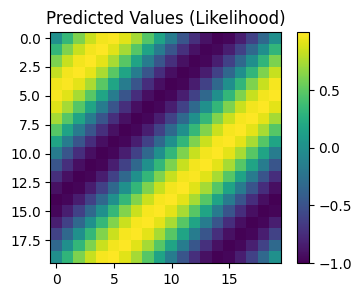

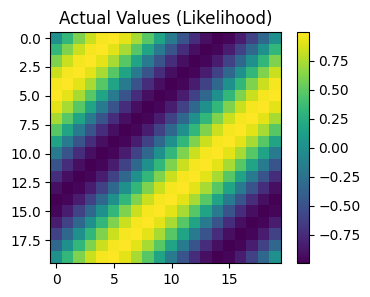

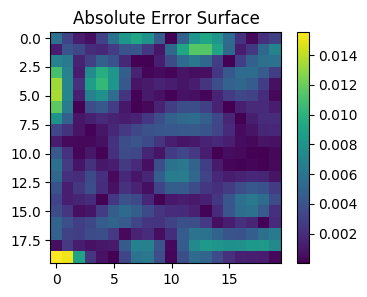

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

pred_labels = observed_pred.mean.view(n, n)

# Calc abosolute error
test_y_actual = torch.sin(((test_x[:, 0] + test_x[:, 1]) * (2 * math.pi))).view(n, n)
delta_y = torch.abs(pred_labels - test_y_actual).detach().numpy()

# Define a plotting function
def ax_plot(f, ax, y_labels, title):
    if smoke_test: return  # this is for running the notebook in our testing framework
    im = ax.imshow(y_labels)
    ax.set_title(title)
    f.colorbar(im)

# Plot our predictive means
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax, pred_labels, 'Predicted Values (Likelihood)')

# Plot the true values
f, observed_ax2 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax2, test_y_actual, 'Actual Values (Likelihood)')

# Plot the absolute errors
f, observed_ax3 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax3, delta_y, 'Absolute Error Surface')